
#### Network Compression using SVD for MNIST

In [0]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [0]:
#Reading the MNIST image files
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Incorporated the Xavier initialization as it gives above 98% accuracy, as a baseline model to go forward with building a compressed network:<br>
-> Input dimentsions = 784 <br>
-> 5 hidden layers with 1024 hidden units each <br>
-> Xavier Initialization for and weights Random normal initialization for biases<br>
-> Adam optimizer and cross entropy loss function with logits.<br>
-> ReLu activation function for all the layers.<br>
-> Default learning rate of Adam Optimizer = 0.001 <br>
-> Output Layer dimensions = 10 (0-9 classes)

In [0]:
#Defining the neural network for baseline
#MNIST Classification 0-9 - 10 classes one hot encoded

#Hidden layers:
n_nodes_hl1 = 1024
n_nodes_hl2 = 1024
n_nodes_hl3 = 1024
n_nodes_hl4 = 1024
n_nodes_hl5 = 1024


#Classes
n_classes = 10
batch_size = 150
n_epochs = 30

x = tf.placeholder('float',[None,784])
y = tf.placeholder('float')

In [0]:
random.seed(50)
data = x
h1 = {'w':tf.Variable(tf.contrib.layers.xavier_initializer()([784,n_nodes_hl1])),'b':tf.Variable(tf.random_normal([n_nodes_hl1]))}
h2 = {'w':tf.Variable(tf.contrib.layers.xavier_initializer()([n_nodes_hl1,n_nodes_hl2])),'b':tf.Variable(tf.random_normal([n_nodes_hl2]))}
h3 = {'w':tf.Variable(tf.contrib.layers.xavier_initializer()([n_nodes_hl2,n_nodes_hl3])),'b':tf.Variable(tf.random_normal([n_nodes_hl3]))}
h4 = {'w':tf.Variable(tf.contrib.layers.xavier_initializer()([n_nodes_hl3,n_nodes_hl4])),'b':tf.Variable(tf.random_normal([n_nodes_hl4]))}
h5 = {'w':tf.Variable(tf.contrib.layers.xavier_initializer()([n_nodes_hl4,n_nodes_hl5])),'b':tf.Variable(tf.random_normal([n_nodes_hl5]))}
output_layer = {'w':tf.Variable(tf.contrib.layers.xavier_initializer()([n_nodes_hl5,n_classes])),'b':tf.Variable(tf.random_normal([n_classes]))}
keep_prob = tf.placeholder(tf.float32)

#(input_data*weights) + biases
l1 = tf.add(tf.matmul(data, h1['w']),h1['b'])
l1 = tf.nn.relu(l1)
l2 = tf.add(tf.matmul(l1, h2['w']),h2['b'])
l2 = tf.nn.relu(l2)
l3 = tf.add(tf.matmul(l2, h3['w']),h3['b'])
l3 = tf.nn.relu(l3)
l4 = tf.add(tf.matmul(l3, h4['w']),h4['b'])
l4 = tf.nn.relu(l4)
l5 = tf.add(tf.matmul(l4, h5['w']),h5['b'])
l5 = tf.nn.relu(l5)

output = tf.add(tf.matmul(l5, output_layer['w']),output_layer['b'])

pred = output
cost_func = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y) )
optimizer = tf.train.AdamOptimizer().minimize(cost_func)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for epoch in range(n_epochs):
  epoch_loss = 0
  for _ in range(int(mnist.train.num_examples/batch_size)):
    epoch_x,epoch_y = mnist.train.next_batch(batch_size)
    _,c = sess.run([optimizer,cost_func], feed_dict = {x:epoch_x, y:epoch_y})
    epoch_loss += c
  print('epoch',epoch,'loss',epoch_loss)
correct = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct,'float'))
print('Accuracy',sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})*100, "%")


epoch 0 loss 185.48808801174164
epoch 1 loss 43.385691637173295
epoch 2 loss 28.73910706723109
epoch 3 loss 21.38529244204983
epoch 4 loss 18.401518031721935
epoch 5 loss 13.538994213799015
epoch 6 loss 12.057347120397026
epoch 7 loss 10.034107898332877
epoch 8 loss 9.726478597061941
epoch 9 loss 8.027179803873878
epoch 10 loss 8.71093807775469
epoch 11 loss 8.18182961284765
epoch 12 loss 6.597328985400964
epoch 13 loss 7.298225230748358
epoch 14 loss 7.506153215043014
epoch 15 loss 5.928964845541486
epoch 16 loss 6.438356898124766
epoch 17 loss 5.234458309336333
epoch 18 loss 6.148189006822577
epoch 19 loss 4.687322076832061
epoch 20 loss 4.5483121237957675
epoch 21 loss 4.201057384332671
epoch 22 loss 6.912414456704937
epoch 23 loss 3.7581618744316074
epoch 24 loss 4.428032477248053
epoch 25 loss 4.013434745966151
epoch 26 loss 4.411360191781569
epoch 27 loss 4.3473117967575945
epoch 28 loss 8.036905290613504
epoch 29 loss 2.773205591518007
Accuracy 98.07999730110168 %


Ran Singular Value Decomposition on all the five layers,

In [0]:
s1, u1, v1 = tf.svd(h1['w'])

s2, u2, v2 = tf.svd(h2['w'])

s3, u3, v3 = tf.svd(h3['w'])

s4, u4, v4 = tf.svd(h4['w'])

s5, u5, v5 = tf.svd(h5['w'])

d = tf.placeholder(tf.int32, shape = (), name = "d")

In [0]:


l1_svd = tf.matmul(tf.multiply(tf.matmul(x, u1[:,:d]), s1[:d]), tf.transpose(v1)[:d,:]) + h1['b']
l1_svd = tf.nn.relu(l1_svd)
l2_svd = tf.matmul(tf.multiply(tf.matmul(l1_svd, u2[:,:d]), s2[:d]), tf.transpose(v2)[:d,:]) + h2['b']
l2_svd = tf.nn.relu(l2_svd)
l3_svd = tf.matmul(tf.multiply(tf.matmul(l2_svd, u3[:,:d]), s3[:d]), tf.transpose(v3)[:d,:]) + h3['b']
l3_svd = tf.nn.relu(l3_svd)
l4_svd = tf.matmul(tf.multiply(tf.matmul(l3_svd, u4[:,:d]), s4[:d]), tf.transpose(v4)[:d,:]) + h4['b']
l4_svd = tf.nn.relu(l4_svd)
l5_svd = tf.matmul(tf.multiply(tf.matmul(l4_svd, u5[:,:d]), s5[:d]), tf.transpose(v5)[:d,:]) + h5['b']
l5_svd = tf.nn.relu(l5_svd)

output_svd = tf.add(tf.matmul(l5_svd, output_layer['w']),output_layer['b'])
pred_svd = output_svd

cost_func_svd = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=pred_svd, labels=y) )
optimizer_svd = tf.train.AdamOptimizer().minimize(cost_func_svd)

correct_svd = tf.equal(tf.argmax(pred_svd, 1), tf.argmax(y, 1))
accuracy_svd = tf.reduce_mean(tf.cast(correct_svd, 'float'))

1.5) As can be seen in the graph the best performance is for $D{full}$, and the worst performance is for D = 10.

Text(0, 0.5, 'Test Accuracy')

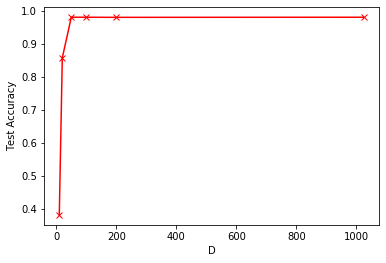

In [0]:
# D_full being 1024
D_vals = [10, 20, 50, 100, 200, 1024]
accu = []

for i in range(len(D_vals)):
  accu.append(sess.run(accuracy_svd, feed_dict = {d: D_vals[i], x:mnist.test.images, y:mnist.test.labels})) 
plt.plot(D_vals, accu, 'rx-')
plt.xlabel("D")
plt.ylabel("Test Accuracy")

#### 1.6) Fixing the value of D = 20

Following the first approach, as stated in 1.6(a), 

In [0]:

S1, U1, V1, b1 = sess.run([s1, u1, v1, h1['b']])
S2, U2, V2, b2 = sess.run([s2, u2, v2, h2['b']])
S3, U3, V3, b3 = sess.run([s3, u3, v3, h3['b']])
S4, U4, V4, b4 = sess.run([s4, u4, v4, h4['b']])
S5, U5, V5, b5 = sess.run([s5, u5, v5, h5['b']])
opW, opB = output_layer['w'],output_layer['b']


As the network initially, was slow in training, I have casted the S,U,V under tf.Variable() and then re-structured it.

In [0]:
d = 20

V1 = tf.Variable((S1[:d]*V1[:, :d]).T)
U1 = tf.Variable(U1[:,:d])
b1 = tf.Variable(b1)

V2 = tf.Variable((S2[:d]*V2[:, :d]).T)
U2 = tf.Variable(U2[:,:d])
b2 = tf.Variable(b2)

V3 = tf.Variable((S3[:d]*V3[:, :d]).T)
U3 = tf.Variable(U3[:,:d])
b3 = tf.Variable(b3)

V4 = tf.Variable((S4[:d]*V4[:, :d]).T)
U4 = tf.Variable(U4[:,:d])
b4 = tf.Variable(b4)

V5 = tf.Variable((S5[:d]*V5[:, :d]).T)
U5 = tf.Variable(U5[:,:d])
b5 = tf.Variable(b5)

opW = tf.Variable(opW)
opB = tf.Variable(opB)


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


In [0]:
to_be_init_vars = [V1, U1, V2, U2, V3, U3, V4, U4, V5, U5, b1, b2, b3, b4, b5, opW, opB]

init_1 = tf.variables_initializer(to_be_init_vars)
sess.run(init_1)

In [0]:

l1_svd_20 = tf.add(tf.matmul(x,(tf.matmul(U1,V1))), b1)
l1_svd_20 = tf.nn.relu(l1_svd_20)

l2_svd_20 = tf.add(tf.matmul(l1_svd_20,(tf.matmul(U2,V2))), b2)
l2_svd_20 = tf.nn.relu(l2_svd_20)

l3_svd_20 = tf.add(tf.matmul(l2_svd_20,(tf.matmul(U3,V3))), b3)
l3_svd_20 = tf.nn.relu(l3_svd_20)

l4_svd_20 = tf.add(tf.matmul(l3_svd_20,(tf.matmul(U4,V4))), b4)
l4_svd_20 = tf.nn.relu(l4_svd_20)

l5_svd_20 = tf.add(tf.matmul(l4_svd_20,(tf.matmul(U5,V5))), b5)
l5_svd_20 = tf.nn.relu(l5_svd_20)

l_op_20 = tf.matmul(l5_svd_20, opW)+ opB



In [0]:
#Setting a low learning rate of 0.00001

init_vars = set(tf.global_variables())
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = l_op_20, labels = y))
optimizer = tf.train.AdamOptimizer(0.00001).minimize(cost)
sess.run(tf.variables_initializer(set(tf.global_variables()) - init_vars))

correct = tf.equal(tf.argmax(l_op_20, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [0]:

for epoch in range(n_epochs):
    epoch_loss = 0
    for _ in range(int(mnist.train.num_examples/batch_size)):
        epoch_x, epoch_y = mnist.train.next_batch(batch_size)
        _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
        epoch_loss += c
    print("epoch",epoch, "epoch loss", epoch_loss)


epoch 0 epoch loss 89.44561988860369
epoch 1 epoch loss 52.2577834315598
epoch 2 epoch loss 44.71851280145347
epoch 3 epoch loss 38.5176507383585
epoch 4 epoch loss 35.71346833743155
epoch 5 epoch loss 32.921982002444565
epoch 6 epoch loss 30.683997925836593
epoch 7 epoch loss 28.378394033759832
epoch 8 epoch loss 27.095213156193495
epoch 9 epoch loss 25.532018517144024
epoch 10 epoch loss 24.60654608020559
epoch 11 epoch loss 23.021764043718576
epoch 12 epoch loss 22.58966112881899
epoch 13 epoch loss 21.595755398273468
epoch 14 epoch loss 20.493986262008548
epoch 15 epoch loss 20.02113056834787
epoch 16 epoch loss 19.33806428220123
epoch 17 epoch loss 18.682646145112813
epoch 18 epoch loss 17.852592464303598
epoch 19 epoch loss 17.438902121735737
epoch 20 epoch loss 16.517872279859148
epoch 21 epoch loss 16.701299568405375
epoch 22 epoch loss 15.540785312652588
epoch 23 epoch loss 15.481235947925597
epoch 24 epoch loss 14.717421644134447
epoch 25 epoch loss 14.742009248351678
epoch 2

In [0]:


acc = sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})
print('Test Accuracy for D = 20 is ', acc*100)


Test Accuracy for D = 20 is  97.79000282287598


The compressed neural network gives an accuracy which is 97.7%accuracycompared to the fully connected baseline network (98% accuracy). But the compressed network uses only 4% of the memory that of fully connected network, which is appreciable.